In the previous post, I discussed a linearization procedure that could be used to solve a nonlinear diffusion equation. We saw that the linearization converted the nonlinear diffusion equation to a PDE with linear diffusion and convection terms. Here, I'm going to solve that equation again, but this time on a nonuniform mesh. My objective is to see what happens if we choose an averaging term that is not consistent with the chosen method for the discretization of the convection term.

In [8]:
using JFVM, PyPlot

In [18]:
function diffusion_newton(conv_method, avg_method)
    L= 1.0 # domain length
    Nx= 100
    dx_min=L/Nx
        x=[0.0, dx_min]
    while x[end]<L
        push!(x, x[end]+1.05(x[end]-x[end-1]))
    end
    x[end]=L
    m= createMesh1D(x) # create a nonuniform 1D mesh
    D0= 1.0 # diffusion coefficient constant
    # Define the diffusion coefficientand its derivative
    D(phi)=D0*(1.0+phi.^2)
    dD(phi)=2.0*D0*phi
    # create boundary condition
    BC = createBC(m)
    BC.left.a[:]=0.0
    BC.left.b[:]=1.0
    BC.left.c[:]=5.0
    BC.right.a[:]=0.0
    BC.right.b[:]=1.0
    BC.right.c[:]=0.0
    (Mbc, RHSbc)= boundaryConditionTerm(BC)
    # define the initial condition
    phi0= 0.0 # initial value
    phi_old= createCellVariable(m, phi0, BC) # create initial cells
    phi_val= copyCell(phi_old)
    # initialize the solution for upwind case
    phi_face= linearMean(phi_val)
    u= -faceEval(dD, phi_face).*gradientTerm(phi_val)
    # define the time steps
    dt= 0.01*L*L/D0 # a proper time step for diffusion process
    for i=1:10
        err=100
        (Mt, RHSt) = transientTerm(phi_old, dt)
        while err>1e-10
            # calculate the diffusion coefficient
            Dface= harmonicMean(cellEval(D,phi_val))
            # calculate the face value of phi_0
            if avg_method==1
                phi_face= linearMean(phi_val)
            elseif avg_method==2
                phi_face= arithmeticMean(phi_val)
            elseif avg_method==3
                phi_face= upwindMean(phi_val, u)
            end
            # calculate the velocity for convection term
            u= -faceEval(dD, phi_face).*gradientTerm(phi_val)
            # diffusion term
            Mdif= diffusionTerm(Dface)
            # convection term
            if conv_method==1
                Mconv= convectionTerm(u)
            elseif conv_method==2
                Mconv= convectionTerm(u)
            elseif conv_method==3
                Mconv= convectionUpwindTerm(u)
            end
            # divergence term on the RHS
            RHSlin= divergenceTerm(u.*phi_face)
            # matrix of coefficients
            M= Mt-Mdif+Mconv+Mbc
            # RHS vector
            RHS= RHSbc+RHSt+RHSlin
            # call the linear solver
            phi_new= solveLinearPDE(m, M, RHS)
            # calculate the error
            err= maximum(abs(phi_new.value-phi_val.value))
            # assign the new phi to the old phi
            phi_val=copyCell(phi_new)
        end
        phi_old= copyCell(phi_val)
        visualizeCells(phi_val)
    end
    return phi_val
end

diffusion_newton (generic function with 1 method)

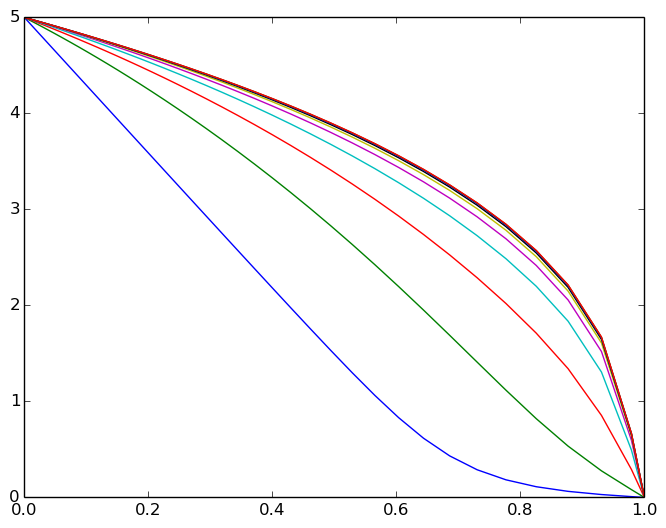

CellValue{Float64}(MeshStructure(1,[37],CellSize{Float64}([0.01,0.01,0.0105,0.011025,0.0115763,0.0121551,0.0127628,0.013401,0.014071,0.0147746  …  0.0392013,0.0411614,0.0432194,0.0453804,0.0476494,0.0500319,0.0525335,0.0551602,0.0416368,0.0416368],[0.0],[0.0]),CellLocation{Float64}([0.005,0.01525,0.0260125,0.0373131,0.0491788,0.0616377,0.0747196,0.0884556,0.102878,0.118022  …  0.565359,0.603626,0.643808,0.685998,0.730298,0.776813,0.825654,0.876936,0.930783,0.979182],[0.0],[0.0]),FaceLocation{Float64}([0.0,0.01,0.0205,0.031525,0.0431013,0.0552563,0.0680191,0.0814201,0.0954911,0.110266  …  0.584026,0.623227,0.664388,0.707608,0.752988,0.800638,0.85067,0.903203,0.958363,1.0],[0.0],[0.0]),[1],[1]),[5.00894,4.99106,4.9726,4.95307,4.93241,4.91053,4.88736,4.86279,4.83674,4.8091  …  3.55996,3.4181,3.25636,3.06891,2.84648,2.57288,2.21444,1.67135,0.667235,-0.667235])

In [23]:
phi_n=diffusion_newton(1,1)

In [16]:
function diffusion_direct()
    L= 1.0 # domain length
    Nx= 100
    dx_min=L/Nx
        x=[0.0, dx_min]
    while x[end]<L
        push!(x, x[end]+1.05(x[end]-x[end-1]))
    end
    x[end]=L
    m= createMesh1D(x) # create a nonuniform 1D mesh
    D0= 1.0 # diffusion coefficient constant
    # Define the diffusion coefficientand its derivative
    D(phi)=D0*(1.0+phi.^2)
    dD(phi)=2.0*D0*phi
    # create boundary condition
    BC = createBC(m)
    BC.left.a[:]=0.0
    BC.left.b[:]=1.0
    BC.left.c[:]=5.0
    BC.right.a[:]=0.0
    BC.right.b[:]=1.0
    BC.right.c[:]=0.0
    (Mbc, RHSbc)= boundaryConditionTerm(BC)
    # define the initial condition
    phi0= 0.0 # initial value
    phi_old= createCellVariable(m, phi0, BC) # create initial cells
    phi_val= copyCell(phi_old)
    # define the time steps
    dt= 0.01*L*L/D0 # a proper time step for diffusion process
    for i=1:10
        err=100
        (Mt, RHSt) = transientTerm(phi_old, dt)
        while err>1e-10
            # calculate the diffusion coefficient
            Dface= harmonicMean(cellEval(D,phi_val))
            # diffusion term
            Mdif= diffusionTerm(Dface)
            # matrix of coefficients
            M= Mt-Mdif+Mbc
            # RHS vector
            RHS= RHSbc+RHSt
            # call the linear solver
            phi_new= solveLinearPDE(m, M, RHS)
            # calculate the error
            err= maximum(abs(phi_new.value-phi_val.value))
            # assign the new phi to the old phi
            phi_val=copyCell(phi_new)
        end
        phi_old= copyCell(phi_val)
        visualizeCells(phi_val)
    end
    return phi_val
end

diffusion_direct (generic function with 1 method)

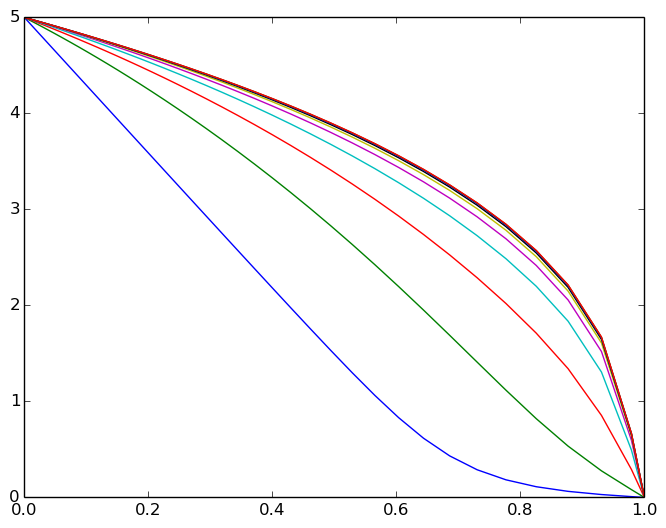

CellValue{Float64}(MeshStructure(1,[37],CellSize{Float64}([0.01,0.01,0.0105,0.011025,0.0115763,0.0121551,0.0127628,0.013401,0.014071,0.0147746  …  0.0392013,0.0411614,0.0432194,0.0453804,0.0476494,0.0500319,0.0525335,0.0551602,0.0416368,0.0416368],[0.0],[0.0]),CellLocation{Float64}([0.005,0.01525,0.0260125,0.0373131,0.0491788,0.0616377,0.0747196,0.0884556,0.102878,0.118022  …  0.565359,0.603626,0.643808,0.685998,0.730298,0.776813,0.825654,0.876936,0.930783,0.979182],[0.0],[0.0]),FaceLocation{Float64}([0.0,0.01,0.0205,0.031525,0.0431013,0.0552563,0.0680191,0.0814201,0.0954911,0.110266  …  0.584026,0.623227,0.664388,0.707608,0.752988,0.800638,0.85067,0.903203,0.958363,1.0],[0.0],[0.0]),[1],[1]),[5.00894,4.99106,4.9726,4.95307,4.93241,4.91053,4.88736,4.86279,4.83674,4.8091  …  3.55996,3.4181,3.25636,3.06891,2.84648,2.57288,2.21444,1.67135,0.667235,-0.667235])

In [17]:
phi_ds=diffusion_direct()

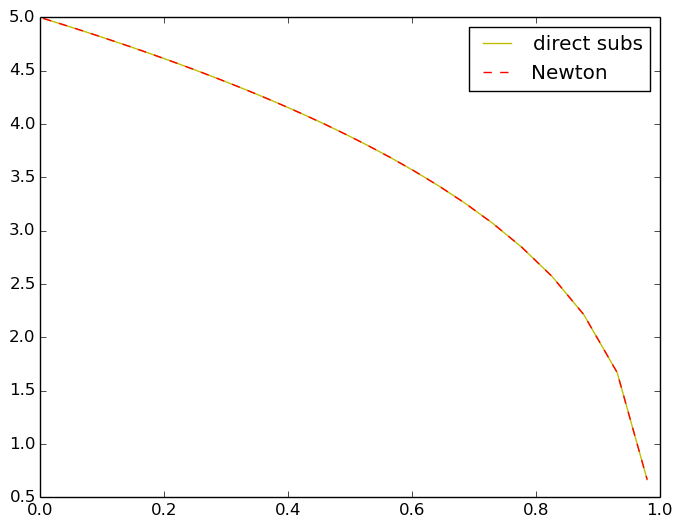

PyObject <matplotlib.legend.Legend object at 0x7f15b30fbb10>

In [24]:
plot(phi_ds.domain.cellcenters.x, phi_ds.value[2:end-1], "y",
phi_n.domain.cellcenters.x, phi_n.value[2:end-1], "--r") 
legend(["direct subs", "Newton"])